In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import f1_score,accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

In [ ]:
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini
# Select the best split point for a dataset
def get_split_gini(dataset):
    class_values = list(set(row[-1] for row in dataset))
    gini_all=[]
    for index in range(len(dataset[0])-1):
        value= np.mean([row[index] for row in dataset])
        groups = test_split(index, value, dataset)
        gini = gini_index(groups, class_values)
        gini_all.append([index,gini])
    gini_all.sort(key= lambda x: x[1])
    return [g[0] for g in gini_all][:5]

In [ ]:
def info_gain(groups, classes,dataset):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    infogain = 0.0
    for class_val in classes:
            p = [row[-1] for row in dataset].count(class_val) / n_instances
            if p == 0.0 :
              continue
            infogain += - p * np.log2(p)
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            if p == 0.0 :
              continue
            score += - p * np.log2(p)
        # weight the group score by its relative size
        infogain -= (score) * (size / n_instances)
    return infogain
def get_split_info_gain(dataset):
    class_values = list(set(row[-1] for row in dataset))
    info_all=[]
    for index in range(len(dataset[0])-1):
        value= np.mean([row[index] for row in dataset])
        groups = test_split(index, value, dataset)
        info = info_gain(groups, class_values,dataset)
        info_all.append([index,info])
    info_all.sort(key= lambda x: x[1],reverse =True)
    return [g[0] for g in info_all][:5]

In [ ]:
def gain_ratio(groups, classes,dataset):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    infogain = 0.0
    splitinfo = 0.0
    for class_val in classes:
            p = [row[-1] for row in dataset].count(class_val) / n_instances
            if p == 0.0 :
              continue
            infogain += - p * np.log2(p)
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        n=size/n_instances
        splitinfo -=  n * np.log2(n)
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            if p == 0.0 :
              continue
            score += - p * np.log2(p)
        # weight the group score by its relative size
        infogain -= (score) * (size / n_instances)
    # print(splitinfo)
    if splitinfo != 0.0 :
      return infogain/splitinfo
    else :
      return None
def get_split_gain_ratio(dataset):
    class_values = list(set(row[-1] for row in dataset))
    gr_all=[]
    for index in range(len(dataset[0])-1):
        value=np.mean([row[index] for row in dataset])
        groups = test_split(index, value, dataset)
        gr = gain_ratio(groups, class_values,dataset)
        if gr != None:
          gr_all.append([index,gr])
    gr_all.sort(key= lambda x: x[1],reverse =True)
    return [g[0] for g in gr_all][:5]

In [ ]:
def mc_error(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    error = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        prob = []
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            prob.append(p)
        # weight the group score by its relative size
        
        error += (1.0 - np.amax(prob)) * (size / n_instances)
    return error
# Select the best split point for a dataset
def get_split_mc_error(dataset):
    class_values = list(set(row[-1] for row in dataset))
    error_all=[]
    for index in range(len(dataset[0])-1):
        value=np.mean([row[index] for row in dataset])
        groups = test_split(index, value, dataset)
        error = mc_error(groups, class_values)
        error_all.append([index,error])
    error_all.sort(key= lambda x: x[1])
    return [e[0] for e in error_all][:5]

In [ ]:
def chi_square(groups, classes,dataset):
    # count all samples at split point
    count_group=[len(group) for group in groups]
    n_instances = float(sum(count_group))
    count_class=[]
    for class_val in classes:
            count_class.append([row[-1] for row in dataset].count(class_val))
    expected_matrix=[c*g/n_instances for g in count_group for c in count_class]
    chi = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        prob = []
        for class_val in classes:
            n = [row[-1] for row in group].count(class_val) 
            ind=(groups.index(group)*2 + classes.index(class_val))
            chi+= (n-expected_matrix[ind])**2/expected_matrix[ind]
    return chi
# Select the best split point for a dataset
def get_split_chi_square(dataset):
    class_values = list(set(row[-1] for row in dataset))
    chi_all=[]
    for index in range(len(dataset[0])-1):
        value=np.mean([row[index] for row in dataset])
        groups = test_split(index, value, dataset)
        chi = chi_square(groups, class_values,dataset)
        chi_all.append([index,chi])
    chi_all.sort(key= lambda x: x[1],reverse=True)
    return [c[0] for c in chi_all][:5]

In [ ]:
gini_toplogn=[]
info_toplogn=[]
gr_toplogn=[]
mc_error_toplogn=[]
chi_toplogn=[]
with tf.device('/device:GPU:0'):
  for i in range(1,57):
        print(i)
        df=pd.read_csv('/content/drive/My Drive/DM_assignment/'+str(i)+'.csv',header= None)
        dfnew=df.copy()
        dfnew[len(df.columns)-1]=df[len(df.columns)-1].map(lambda x : int(x>0))
        dflist=dfnew.values.tolist()
        
        index_gini= get_split_gini(dflist)
        gini_toplogn.append(index_gini)
        
        index_info=get_split_info_gain(dflist)
        info_toplogn.append(index_info)
        
        index_gr=get_split_gain_ratio(dflist)
        gr_toplogn.append(index_gr)

        index_mc=get_split_mc_error(dflist)
        mc_error_toplogn.append(index_mc)

        index_chi=get_split_chi_square(dflist)
        chi_toplogn.append(index_chi)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


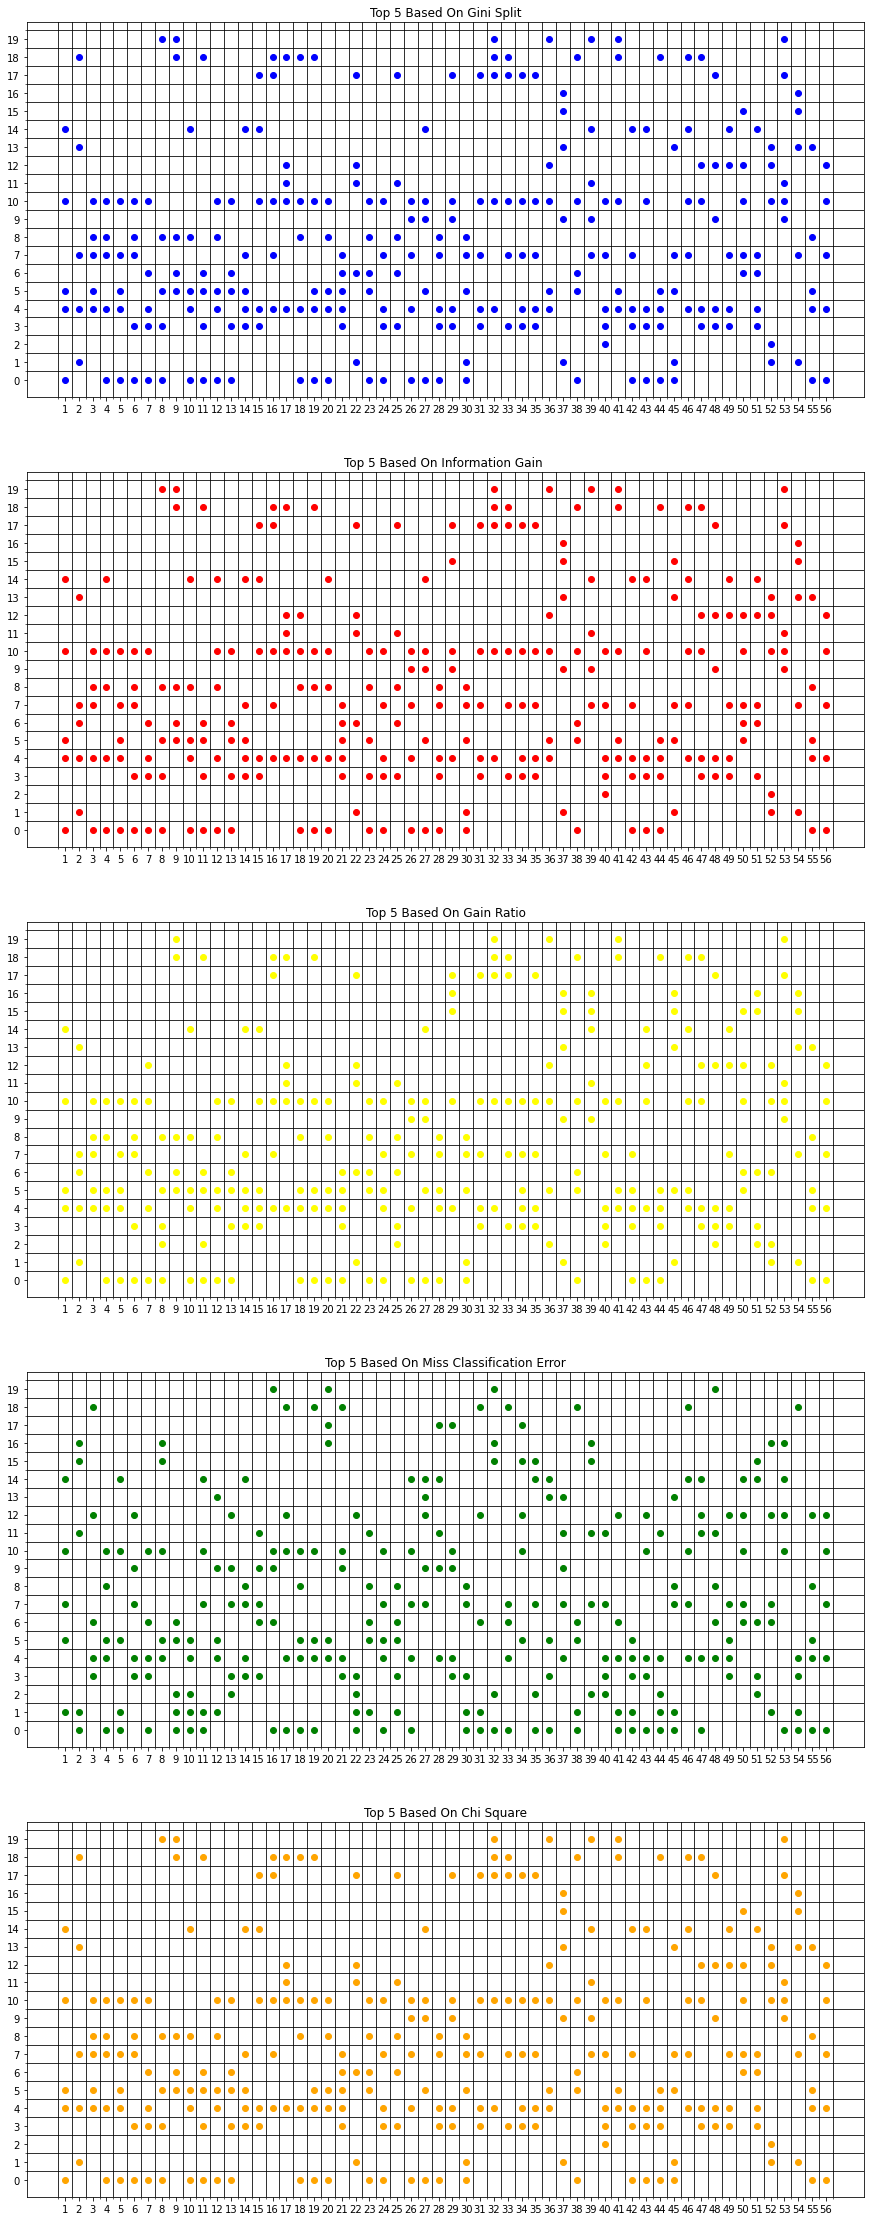

In [ ]:
fig, ax =plt.subplots(5,figsize=(15,40))
for i in range(5):
  ax[i].set_yticks(range(0,20))
  ax[i].set_xticks(range(1,57))
  ax[i].minorticks_on()
  ax[i].xaxis.set_minor_locator(plt.FixedLocator(np.arange(0.5,57.5)))
  ax[i].yaxis.set_minor_locator(plt.FixedLocator(np.arange(0.5,20.5)))
  ax[i].grid(which='minor',color='black')
colours=['blue','red','yellow','green','orange']
for i,feature in enumerate([gini_toplogn,info_toplogn,gr_toplogn,mc_error_toplogn,chi_toplogn]):
  for x,y in zip(range(1,57),feature):
    ax[i].scatter([x]*len(y),y,c=colours[i])
ax[0].set_title("Top 5 Based On Gini Split",color='black')
ax[1].set_title("Top 5 Based On Information Gain ",color='black')
ax[2].set_title("Top 5 Based On Gain Ratio",color='black')
ax[3].set_title("Top 5 Based On Miss Classification Error",color='black')
ax[4].set_title("Top 5 Based On Chi Square",color='black')
# plt.savefig('/content/drive/My Drive/DM_assignment2/top5all.jpg')

In [ ]:
df_gini=pd.DataFrame((np.array([np.array(i) for i in gini_toplogn])),index=range(1,57),columns=range(1,6))
df_gini.to_csv('/content/drive/My Drive/DM_assignment2/gini.csv')

df_info=pd.DataFrame((np.array([np.array(i) for i in info_toplogn])),index=range(1,57),columns=range(1,6))
df_info.to_csv('/content/drive/My Drive/DM_assignment2/info_gain.csv')

df_gr=pd.DataFrame((np.array([np.array(i) for i in gr_toplogn])),index=range(1,57),columns=range(1,6))
df_gr.to_csv('/content/drive/My Drive/DM_assignment2/gain_ratio.csv')

df_mc=pd.DataFrame((np.array([np.array(i) for i in mc_error_toplogn])),index=range(1,57),columns=range(1,6))
df_mc.to_csv('/content/drive/My Drive/DM_assignment2/mc_error.csv')

df_chi=pd.DataFrame((np.array([np.array(i) for i in chi_toplogn])),index=range(1,57),columns=range(1,6))
df_chi.to_csv('/content/drive/My Drive/DM_assignment2/chi_square.csv')